#Setup

Installing the required dependencies to run the project and to use the dataset. To upload the file kaggle.json file, follow the steps below:
1. Go to [Kaggle](http://kaggle.com)
2. Click on the profile picture -> Account
3. Go to the API section -> Expire API Token (to invalidate any previously issued API keys) -> Create New API Token

This will result in a kaggle.json to be downloaded on the device. The kaggle.json can be reused for each session of the program.

In [ ]:
!pip install -q tensorflow==2.4.1

     |████████████████████████████████| 394.3MB 42kB/s 
     |████████████████████████████████| 2.9MB 40.8MB/s 
     |████████████████████████████████| 471kB 38.8MB/s 
     |████████████████████████████████| 3.8MB 25.7MB/s 


In [ ]:
!pip install -q tensorflow-quantum

     |████████████████████████████████| 7.8MB 2.9MB/s 
     |████████████████████████████████| 5.6MB 27.9MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
     |████████████████████████████████| 1.3MB 32.3MB/s 
     |████████████████████████████████| 92kB 8.7MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 1.5MB 38.1MB/s 
     |████████████████████████████████| 389kB 40.9MB/s 


The quantum convolutional neural network used here is from the [QCNN](https://arxiv.org/ct?url=https%3A%2F%2Fdx.doi.org%2F10.1038%2Fs41567-019-0648-8&v=610647cd) by Cong and colleagues and the code has been obtained from [Google Colaboratory](https://www.tensorflow.org/quantum/tutorials/qcnn).

Let us start by importing the required libraries.


In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download grouplens/movielens-20m-dataset -p /content/sample_data/ --unzip

Saving kaggle.json to kaggle.json
 95% 185M/195M [00:01<00:00, 99.4MB/s]
100% 195M/195M [00:01<00:00, 109MB/s] 


#Defining the qubits

In [ ]:
qubit = cirq.GridQubit(0, 0)

# Define some circuits.
circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))
print(circuit1)
print(circuit2)

# Convert to a tensor.
input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])
#print(input_circuit_tensor)

# Define a circuit that we want to append
y_circuit = cirq.Circuit(cirq.Y(qubit))
print(y_circuit)

# Instantiate our layer
y_appender = tfq.layers.AddCircuit()

# Run our circuit tensor through the layer and save the output.
output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)
#print(output_circuit_tensor)

#Examine the input and output tensor
print(tfq.from_tensor(input_circuit_tensor))
print(tfq.from_tensor(output_circuit_tensor))

(0, 0): ───X───
(0, 0): ───H───
(0, 0): ───Y───
[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
])]
[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])]


#Generate Dataset

1. Import the required modules
2. Read the data
3. Convert the users into random users
4. Generate the latest ratings
5. Generate the training set and test set
6. Standardize the dataset around 0 with unit variance
7. Reduce the features to the number of qubits
8. Scale to (-1,1)






In [ ]:
def generate_data():

  import pandas as pd
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler, MinMaxScaler
  from sklearn.decomposition import PCA

  ratings = pd.read_csv('/content/sample_data/rating.csv',parse_dates=['timestamp'])
  """print("Columns:", ratings.columns,"\n")
  print("Dtypes:\n", ratings.dtypes,"\n")
  print("Ndim:",ratings.ndim,"\n")
  print("Size:",ratings.size,"\n")
  print("Shape:",ratings.shape,"\n")
  print("Checking for empty rows:",ratings.empty,"\n")
  print("Desc:\n",ratings.describe(),"\n")
  print("Head:\n",ratings.head(5),"\n")
  print("Sample dataset:\n",ratings.sample(5),"\n")"""

  #Decrease the size of the users
  randUserIDs = np.random.choice(ratings['userId'].unique(), size= int(len(ratings['userId'].unique())*0.3), replace = False)
  ratings = ratings.loc[ratings['userId'].isin(randUserIDs)]
  
  #Latest movies ranked by the date watched
  ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method ='first',ascending = False)
  
  #10% of the dataset is considered for testing
  test_size = int(0.1 * ratings.shape[0])
  data = ratings[['userId','movieId']]
  target = ratings.rating
  train_ratings, test_ratings, train_target, test_target = train_test_split(data, target, test_size=test_size, random_state=42)

  # Now we standardize for gaussian around 0 with unit variance
  std_scale = StandardScaler().fit(train_ratings)
  train_ratings = std_scale.transform(train_ratings)
  test_ratings = std_scale.transform(test_ratings)

  # Now reduce number of features to number of qubits
  n = 2
  pca = PCA(n_components=n).fit(train_ratings)
  train_ratings = pca.transform(train_ratings)
  test_ratings = pca.transform(test_ratings)

  # Scale to the range (-1,+1)
  samples = np.append(train_ratings, test_ratings, axis=0)
  minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
  train_ratings = minmax_scale.transform(train_ratings)
  test_ratings = minmax_scale.transform(test_ratings)

  return tf.convert_to_tensor(train_ratings), train_target.values, tf.convert_to_tensor(test_ratings), test_target.values

In [ ]:
tr_ratings, tr_target, t_ratings, t_target = generate_data()

In [ ]:
print("Ndim:",tr_ratings.ndim,"\n")
print("Shape:",tr_ratings.shape,"\n")
print(tr_ratings)

Ndim: 2 

Shape: (5402284, 2) 

tf.Tensor(
[[-0.36239046 -0.92550895]
 [-0.49885406 -0.80562989]
 [-0.68127622 -0.52729759]
 ...
 [-0.86844854 -0.43250356]
 [-0.45728125 -0.16996612]
 [-0.48845657 -0.79869926]], shape=(5402284, 2), dtype=float64)


In [ ]:
print("Ndim:",tr_target.ndim,"\n")
print("Shape:",tr_target.shape,"\n")
print(tr_target)

Ndim: 1 

Shape: (5402284,) 

[5.  5.  3.  ... 3.  4.5 4. ]


In [ ]:
print("Ndim:",t_ratings.ndim,"\n")
print("Shape:",t_ratings.shape,"\n")
print(t_ratings)

Ndim: 2 

Shape: (600253, 2) 

tf.Tensor(
[[-0.7274841  -0.47699537]
 [-0.73257618 -0.50946643]
 [-0.35106898 -0.91076059]
 ...
 [-0.69692216 -0.54917162]
 [ 0.05377166 -0.44149423]
 [-0.73905004 -0.54572033]], shape=(600253, 2), dtype=float64)


In [ ]:
print("Ndim:",t_target.ndim,"\n")
print("Shape:",t_target.shape,"\n")
print(t_target)

Ndim: 1 

Shape: (600253,) 

[5. 3. 4. ... 4. 4. 2.]


#Defining layers


##1. Define cluster state

In [ ]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        #print(this_bit, next_bit)
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

Test the function

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


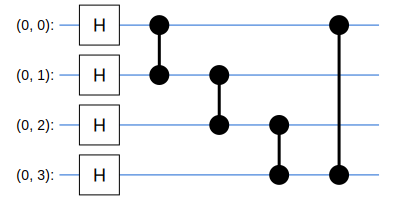

In [ ]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

##2. Unitary circuits

In [ ]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

Test each of the functions

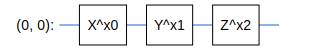

In [ ]:
#print(sympy.symbols('x0:3'))
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))




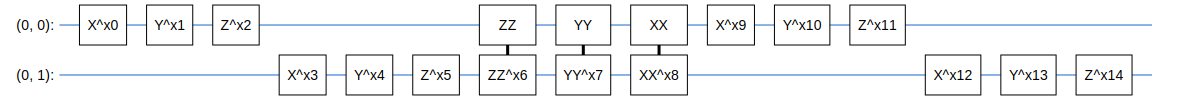

In [ ]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))


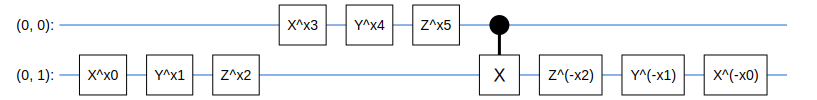

In [ ]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

##3. Convolution layer

In [ ]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        #print(first, second)
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

Test the function

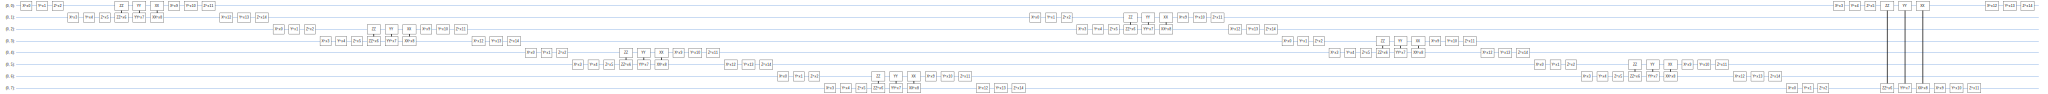

In [ ]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

##4. Pooling layer

In [ ]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

On testing:

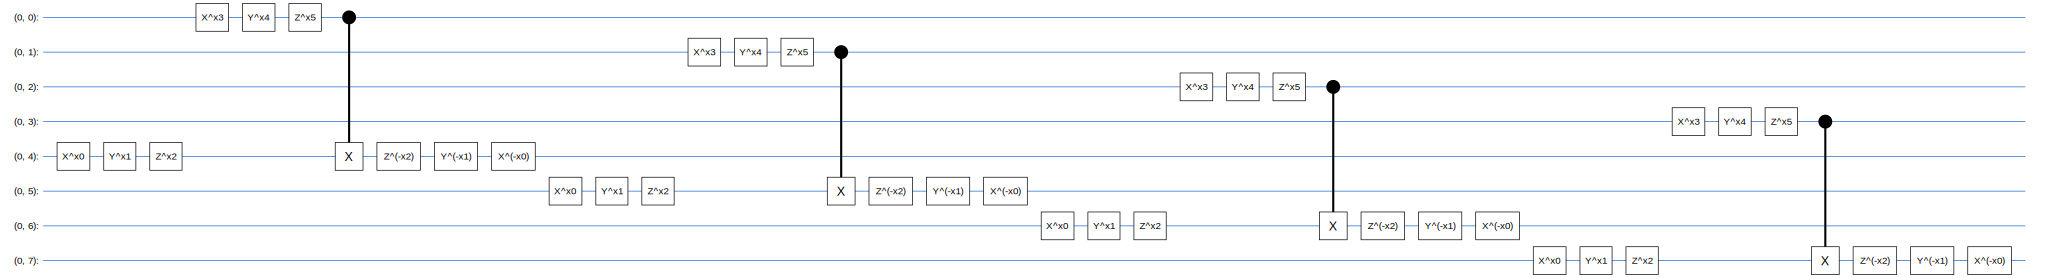

In [ ]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

#Create a CNN model

In [ ]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],
                                          symbols[57:63])
    return model_circuit



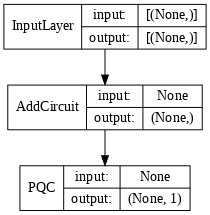

In [ ]:
# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model
# static cluster state prep as a part of the AddCircuit 
ratings_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(ratings_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[ratings_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

#Train the model

In [ ]:
# Generate some training data.
train_ratings, train_labels, test_ratings, test_labels = generate_data()


"""# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred) #x is the rating
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))"""


'# Custom accuracy metric.\n@tf.function\ndef custom_accuracy(y_true, y_pred):\n    y_true = tf.squeeze(y_true)\n    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred) #x is the rating\n    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))'

In [ ]:
"""#Changing the type to float32 from float64
train_R = tf.cast(train_ratings, tf.float32)
test_R = tf.cast(test_ratings, tf.float32)"""

In [ ]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=tf.metrics.categorical_accuracy)

In [ ]:
print(tf.rank(test_ratings))
print(tf.rank(test_labels))
print(test_ratings.shape)
print(train_ratings.shape)

tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
(602183, 2)
(5419656, 2)


In [ ]:
trainL = np.reshape(train_labels,(-1,1))

In [ ]:
data = tf.reshape(train_ratings,(-1,2))

In [ ]:
testL = np.reshape(test_labels,(-1,1))

In [ ]:
data1 = tf.reshape(test_ratings,(-1,2))

In [ ]:
history = qcnn_model.fit(x=data,
                         y=trainL,
                         batch_size=16,
                         epochs=25,
                         verbose=1, #shows the progress bar; can be set to 2 if only the number should be displayed or 0 to not see
                         validation_data=(data1, testL))

Epoch 1/25


ValueError: ignored

In [ ]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()